In [1]:
pwd()
using Pkg; Pkg.activate("../../../FermiCG/")
using FermiCG, NPZ, JLD2
using Plots
using PyCall
using Printf

readdir()

  Activating project at `~/code/FermiCG`
┌ Info: Precompiling FermiCG [855c3b3a-d9bb-4919-8b00-0b3cfbdffb6f]
└ @ Base loading.jl:1423
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423


9-element Vector{String}:
 ".ipynb_checkpoints"
 "Untitled.ipynb"
 "pes_tpsci.jl.570316.scr"
 "pes_tpsci.jl.572434.scr"
 "rerun_tpsci.jl"
 "run_tpsci.sh"
 "scan_cliping.out"
 "tpsci.jl"
 "tpsci.out"

In [2]:
molecule = "
He 0.00000000 0.00000000 0.00000000
He 1.41421356 0.00000000 0.00000000
He 0.00000000 1.41421356 0.00000000
He 1.41421356 1.41421356 0.00000000
He 0.70710678 0.70710678 1.00000000
He 0.70710678 0.70710678 -1.00000000
"
atoms = []
for (li,line) in enumerate(split(rstrip(lstrip(molecule)), "\n"))
    l = split(line)
    push!(atoms, Atom(li, l[1], parse.(Float64,l[2:4])))
end

basis = "cc-pvdz"
# 
# Create FermiCG.Molecule type
mol     = Molecule(0, 1, atoms,basis);


pyscf = pyimport("pyscf")
# pyscf.lib.num_threads(1)


pymol = pyscf.gto.Mole(atom=molecule,
    symmetry = false, spin =0,charge=0,
    basis = basis)

pymol.build()
mf = pyscf.scf.RHF(pymol)
mf.verbose = 4
mf.conv_tol = 1e-8
mf.conv_tol_grad = 1e-5
mf.run(max_cycle=200)

rdm_mf = mf.make_rdm1()

@printf(" Hartree-Fock Energy: %12.8f", mf.e_tot)

pyscfcc = pyimport("pyscf.cc")

mycc = pyscfcc.CCSD(mf).run()
@printf("CCSD total energy    %12.8f\n", mycc.e_tot)
et = mycc.ccsd_t()
@printf("CCSD(T) total energy %12.8f\n", mycc.e_tot + et)



******** <class 'pyscf.scf.hf.RHF'> ********
method = RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-08
SCF conv_tol_grad = 1e-05
SCF max_cycles = 200
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /var/folders/td/qpnnxwv93pq0t7bbdkh5rvzr0000gn/T/tmpxpif9b7n
max_memory 4000 MB (current use 0 MB)
init E= -17.6730314273492
  HOMO = -0.654438527485204  LUMO = 1.43460240889321
cycle= 1 E= -16.8654884601919  delta_E= 0.808  |g|= 0.0892  |ddm|= 0.991
  HOMO = -0.767030395502144  LUMO = 1.42649780614317
cycle= 2 E= -16.8668601687264  delta_E= -0.00137  |g|= 0.0104  |ddm|= 0.0388
  HOMO = -0.763449508276189  LUMO = 1.43042410800101
cycle= 3 E= -16.8668807154648  delta_E= -2.05e-05  |g|= 0.000224  |ddm|= 0.00549
  HOMO = -0.763787559995008  LUMO = 1.43014836141397
cycle= 4 E= -16.8668807264112  delta_E= -1.09e-08  |g|= 1.02e-05  |ddm|= 0.000143
  HOMO = -0.76

In [3]:
n_steps = 40
step_size = .05

pymol_init = pyscf.gto.Mole(atom=molecule,
    symmetry = false, spin =0,charge=0,
    basis = basis)
pymol.build()


io = open("traj.xyz", "w");
energies_scf = []
energies_ccsd = []
energies_ccsdt = []

for R in 1:n_steps

    pymol = deepcopy(pymol_init)
    scale = 1+R*step_size

    xyz = @sprintf("%5i\n\n", length(mol.atoms))
    tmp = []
    for a in mol.atoms
        push!(tmp, ["He", (a.xyz[1]*scale, a.xyz[2]*scale, a.xyz[3]*scale)])
        xyz = xyz * @sprintf("%6s %24.16f %24.16f %24.16f \n", a.symbol, a.xyz[1]*scale, a.xyz[2]*scale, a.xyz[3]*scale)
    end
    pymol.atom = tmp
    pymol.build()
    
    
    println(xyz)
    write(io, xyz);
   
    
#     println(pymol.format_atom(1))
    
    #     mol_R = Molecule(0, 1, [a[0]pymol.atom, pymol.basis)


    mf = pyscf.scf.RHF(pymol)
    mf.verbose = 4
    mf.conv_tol = 1e-8
    mf.conv_tol_grad = 1e-8
    mf.run(max_cycle=200)

    rdm_mf = mf.make_rdm1()

    @printf(" Hartree-Fock Energy: %12.8f", mf.e_tot)

    push!(energies_scf, mf.e_tot)
    
    pyscfcc = pyimport("pyscf.cc")

    mycc = pyscfcc.CCSD(mf).run()
    @printf("CCSD total energy    %12.8f\n", mycc.e_tot)
    
    et = mycc.ccsd_t()
    @printf("CCSD(T) total energy %12.8f\n", mycc.e_tot + et)

    
    push!(energies_ccsd, mycc.e_tot)
    push!(energies_ccsdt, mycc.e_tot+et)

end
close(io);
plot([energies_scf, energies_ccsd, energies_ccsdt])
equil = findmin(energies_ccsdt.-energies_ccsdt[end])
println(equil)


    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       1.4849242380000001       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       1.4849242380000001       0.0000000000000000 
    He       1.4849242380000001       1.4849242380000001       0.0000000000000000 
    He       0.7424621190000000       0.7424621190000000       1.0500000000000000 
    He       0.7424621190000000       0.7424621190000000      -1.0500000000000000 



******** <class 'pyscf.scf.hf.RHF'> ********
method = RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-08
SCF conv_tol_grad = 1e-08
SCF max_cycles = 200
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /var/folders/td/qpnnxwv93pq0t7bbdkh5rvzr0000gn/T/tmpi4hqh0c7
max_memory 4000 MB (current use 0 MB)
init E= -17.5378832431178
  HOMO = -0.692412447912835  LUMO

 Hartree-Fock Energy: -17.04851410E(CCSD) = -17.24525711803478  E_corr = -0.1967430166776295
CCSD total energy    -17.24525712
CCSD(T) correction = -9.27378733050786e-05
CCSD(T) total energy -17.24534986
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       1.7677669500000002       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       1.7677669500000002       0.0000000000000000 
    He       1.7677669500000002       1.7677669500000002       0.0000000000000000 
    He       0.8838834750000001       0.8838834750000001       1.2500000000000000 
    He       0.8838834750000001       0.8838834750000001      -1.2500000000000000 



******** <class 'pyscf.scf.hf.RHF'> ********
method = RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-08
SCF conv_tol_grad = 1e-08
SCF max_cycles = 200
direct_scf = True
direct



******** <class 'pyscf.scf.hf.RHF'> ********
method = RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-08
SCF conv_tol_grad = 1e-08
SCF max_cycles = 200
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /var/folders/td/qpnnxwv93pq0t7bbdkh5rvzr0000gn/T/tmp6lb3nax_
max_memory 4000 MB (current use 0 MB)
init E= -17.1662884639475
  HOMO = -0.854038948133266  LUMO = 1.09783651387309
cycle= 1 E= -17.1133872529511  delta_E= 0.0529  |g|= 0.0177  |ddm|= 0.288
  HOMO = -0.876405164821007  LUMO = 1.099538482676
cycle= 2 E= -17.1134531558926  delta_E= -6.59e-05  |g|= 0.00193  |ddm|= 0.0102
  HOMO = -0.876283124675443  LUMO = 1.0998032990442
cycle= 3 E= -17.1134540068436  delta_E= -8.51e-07  |g|= 4.05e-05  |ddm|= 0.00134
  HOMO = -0.876272972142783  LUMO = 1.09981303724284
cycle= 4 E= -17.1134540072343  delta_E= -3.91e-10  |g|= 2.32e-07  |ddm|= 3.01e-05
  HOMO = -0.87

CCSD(T) correction = -1.2884437468494e-05
CCSD(T) total energy -17.32156153
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       2.4041630520000004       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       2.4041630520000004       0.0000000000000000 
    He       2.4041630520000004       2.4041630520000004       0.0000000000000000 
    He       1.2020815260000002       1.2020815260000002       1.7000000000000002 
    He       1.2020815260000002       1.2020815260000002      -1.7000000000000002 



******** <class 'pyscf.scf.hf.RHF'> ********
method = RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-08
SCF conv_tol_grad = 1e-08
SCF max_cycles = 200
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /var/folders/td/qpnnxwv93pq0t7bbdkh5rvzr0000gn/T/tmpqpexien6
max_memory 4000 MB (c

 Hartree-Fock Energy: -17.13047343E(CCSD) = -17.32522845690141  E_corr = -0.1947550241825132
CCSD total energy    -17.32522846
CCSD(T) correction = -3.14356172773697e-06
CCSD(T) total energy -17.32523160
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       2.7577164420000004       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       2.7577164420000004       0.0000000000000000 
    He       2.7577164420000004       2.7577164420000004       0.0000000000000000 
    He       1.3788582210000002       1.3788582210000002       1.9500000000000002 
    He       1.3788582210000002       1.3788582210000002      -1.9500000000000002 



******** <class 'pyscf.scf.hf.RHF'> ********
method = RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-08
SCF conv_tol_grad = 1e-08
SCF max_cycles = 200
direct_scf = True
direct



******** <class 'pyscf.scf.hf.RHF'> ********
method = RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-08
SCF conv_tol_grad = 1e-08
SCF max_cycles = 200
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /var/folders/td/qpnnxwv93pq0t7bbdkh5rvzr0000gn/T/tmp7w6wldl6
max_memory 4000 MB (current use 0 MB)
init E= -17.1231926479443
  HOMO = -0.911928248671114  LUMO = 1.30867002845334
cycle= 1 E= -17.1309601804413  delta_E= -0.00777  |g|= 0.00396  |ddm|= 0.0525
  HOMO = -0.910919516204778  LUMO = 1.31203376889095
cycle= 2 E= -17.1309634969109  delta_E= -3.32e-06  |g|= 0.000283  |ddm|= 0.0027
  HOMO = -0.910884669230848  LUMO = 1.31206661720755
cycle= 3 E= -17.1309635148066  delta_E= -1.79e-08  |g|= 3.75e-06  |ddm|= 0.000221
  HOMO = -0.910884103806356  LUMO = 1.31206702102168
cycle= 4 E= -17.1309635148098  delta_E= -3.18e-12  |g|= 3.91e-08  |ddm|= 3.02e-06
  HOM

CCSD(T) correction = -1.97255393439593e-07
CCSD(T) total energy -17.32562531
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       3.3941125440000008       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       3.3941125440000008       0.0000000000000000 
    He       3.3941125440000008       3.3941125440000008       0.0000000000000000 
    He       1.6970562720000004       1.6970562720000004       2.4000000000000004 
    He       1.6970562720000004       1.6970562720000004      -2.4000000000000004 



******** <class 'pyscf.scf.hf.RHF'> ********
method = RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-08
SCF conv_tol_grad = 1e-08
SCF max_cycles = 200
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /var/folders/td/qpnnxwv93pq0t7bbdkh5rvzr0000gn/T/tmp90f2bxx8
max_memory 4000 MB (

 Hartree-Fock Energy: -17.13096636E(CCSD) = -17.32559436406088  E_corr = -0.1946280086943958
CCSD total energy    -17.32559436
CCSD(T) correction = -6.2310804855972e-08
CCSD(T) total energy -17.32559443
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       3.7476659340000009       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       3.7476659340000009       0.0000000000000000 
    He       3.7476659340000009       3.7476659340000009       0.0000000000000000 
    He       1.8738329670000005       1.8738329670000005       2.6500000000000004 
    He       1.8738329670000005       1.8738329670000005      -2.6500000000000004 



******** <class 'pyscf.scf.hf.RHF'> ********
method = RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-08
SCF conv_tol_grad = 1e-08
SCF max_cycles = 200
direct_scf = True
direct_



******** <class 'pyscf.scf.hf.RHF'> ********
method = RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-08
SCF conv_tol_grad = 1e-08
SCF max_cycles = 200
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /var/folders/td/qpnnxwv93pq0t7bbdkh5rvzr0000gn/T/tmp3k26u6td
max_memory 4000 MB (current use 0 MB)
init E= -17.1223184154998
  HOMO = -0.917005607156315  LUMO = 1.39068198713242
cycle= 1 E= -17.1309630936996  delta_E= -0.00864  |g|= 0.000911  |ddm|= 0.0217
  HOMO = -0.914034135422059  LUMO = 1.3939166562584
cycle= 2 E= -17.1309632814599  delta_E= -1.88e-07  |g|= 6.48e-05  |ddm|= 0.000702
  HOMO = -0.913994090261745  LUMO = 1.39394883158806
cycle= 3 E= -17.1309632824023  delta_E= -9.42e-10  |g|= 1.18e-06  |ddm|= 5.25e-05
  HOMO = -0.913993918939899  LUMO = 1.39394895163368
cycle= 4 E= -17.1309632824025  delta_E= -2.56e-13  |g|= 3.38e-08  |ddm|= 5.99e-07
  H

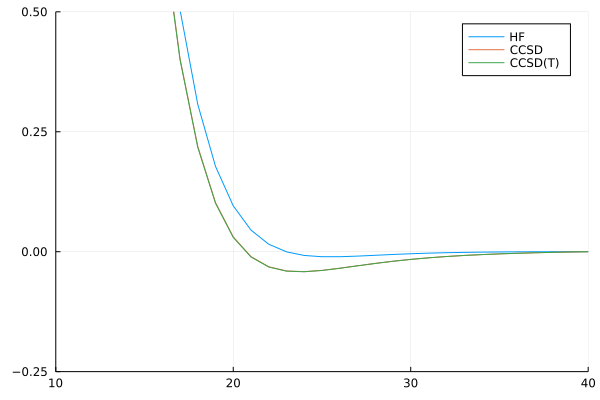

In [6]:
plot([energies_scf.-energies_scf[end], energies_ccsd.-energies_ccsd[end], energies_ccsdt.-energies_ccsdt[end]]*627.51, 
labels = ["HF" "CCSD" "CCSD(T)"])
ylims!((-.25,.5))
xlims!((10,40))